In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

from fpex0 import fpex0
from fpex0.example.exampleSetup import exampleSetup, importExampleMeasurements

In [1]:
def experiment():
    """
    Modified version of exampleFit() for numerical experiments with explicit integration methods.

    ## Returns 
    Collected simulations.
    """
    # make example setup
    print("Creating an example setup.")
    FPEX0setup = exampleSetup('RK45')
    exp_data = []

    # import the example data
    print("Importing example data.")
    FPEX0setup = importExampleMeasurements(FPEX0setup, gridskip=2)

    # modify some configuration (as example)
    print("Setting integration options.")
    FPEX0setup.Integration.options["rtol"] = 1e-8
    FPEX0setup.Integration.options["atol"] = 1e-14

    # fitting
    print("\nSolving the fitting problem:")
    refTime = time.time()
    fit = fpex0.fit(FPEX0setup, sol_info=exp_data)
    duration = time.time() - refTime
    print("Fit complete.")
    print(f"Fit time: {duration}s.")
    print(f"Solution found: p = {fit.x}")

    return exp_data


def process_sim(sim, grid):
    if sim[0].success:
        data = {}
        sol = sim[0]
        data["duration"] = sim[1]
        data["y_cont"] = sol.sol
        data["t"] = sol.t
        data["y"] = sol.y
        data["steps"] = [sol.t[i+1] - sol.t[i] for i in range( len(sol.t)-1 )]
        data["fun_evals"] = sol.nfev
        data["grid"] = grid
    return data


def visualize_result(data):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
    
    # initial distribution
    init_distr = data["y_cont"](0)
    grid = data["grid"]
    ax1.plot(grid, init_distr, label="Initial Distribution")
    ax1.legend()

    # time steps
    time = data["t"]
    steps = data["steps"]
    ax2.set_yscale("log")
    ax2.grid(True)
    ax2.plot(time[:len(steps)], steps, label="Integration steps")
    ax2.legend()

    # time steps, zoomed in
    time_zoomed = np.extract(time <= 1.0, time)
    ax4.set_yscale("log")
    ax4.grid(True)
    ax4.plot(time_zoomed, steps[:len(time_zoomed)], label="Integration steps")
    ax4.legend()

    # delta y
    deriv = [data["y"][i+1][0] - data["y"][i][0] for i in range( len(data["y"])-1 )]
    ax3.plot(grid[:len(deriv)], deriv, label="Delta y")
    ax3.legend()

    # histogram, steps
    ax6.hist(time, bins=20, edgecolor="black", label="Steps by interval")
    ax6.grid(True)
    ax6.legend()

    plt.show()

In [ ]:
sim_data = experiment()

Creating an example setup.
Importing example data.
    /home/mstrik/software/fpex0-project/fpex0_python/fpex0/example/ID407-rate_0.60.json
    /home/mstrik/software/fpex0-project/fpex0_python/fpex0/example/ID407-rate_1.25.json
    /home/mstrik/software/fpex0-project/fpex0_python/fpex0/example/ID407-rate_2.50.json
    /home/mstrik/software/fpex0-project/fpex0_python/fpex0/example/ID407-rate_5.00.json
    /home/mstrik/software/fpex0-project/fpex0_python/fpex0/example/ID407-rate_10.00.json
    /home/mstrik/software/fpex0-project/fpex0_python/fpex0/example/ID407-rate_20.00.json
Setting integration options.

Solving the fitting problem:
Running lsq.



/home/mstrik/software/fpex0-project/py3.10-env/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  warn("The following arguments have no effect for a chosen solver: {}."


Simulate: 0.473s
Simulate: 0.372s
Simulate: 0.343s
Simulate: 0.327s
Simulate: 0.397s
Simulate: 0.378s
Simulate: 0.345s
Simulate: 0.346s
Simulate: 0.366s
Simulate: 0.423s
Simulate: 0.375s
Simulate: 0.439s
Simulate: 0.363s
Simulate: 0.377s
Simulate: 0.324s
Simulate: 0.352s
Simulate: 0.372s
Simulate: 0.341s
Simulate: 0.342s
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0664e+05                                    3.16e+05    
Simulate: 0.960s
Simulate: 0.922s
Simulate: 0.891s
Simulate: 0.927s
Simulate: 0.925s
Simulate: 0.945s
Simulate: 0.933s
Simulate: 0.922s
Simulate: 1.024s
Simulate: 0.947s
Simulate: 1.044s
Simulate: 0.956s
Simulate: 1.090s
Simulate: 1.183s
Simulate: 1.245s
Simulate: 1.043s
Simulate: 0.964s
Simulate: 1.116s
Simulate: 1.131s
       1              2         5.0303e+04      1.56e+05       9.82e+00       2.76e+05    
Simulate: 2.848s
Simulate: 2.765s


: 

: 

In [ ]:
grid = np.linspace(60, 160, 1001)
data = [process_sim(sim, grid) for sim in sim_data]

In [ ]:
data1 = data[0]
data2 = data[21]
data3 = data[41]

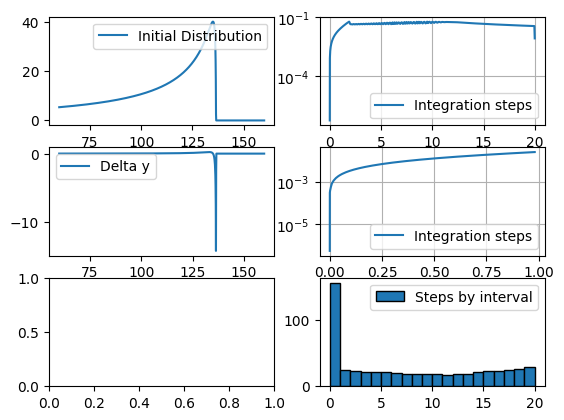

In [ ]:
from experiments import visualize_result
visualize_result(data1)
visualize_result(data2)
visualize_result(data3)

The stepsizes start very small and then reach a rather constant behaviour quickly. This is coherent with what we expected.
In the plot it does not become clear how many these very small steps are. A histogram divided in time intervals will give information about that.

In [ ]:
a = len(np.extract(data1["t"]<=1, data1["t"]))
b = len(np.extract(data1["t"]<=2, data1["t"]))
print(a)
print(b-a)

156
25
